In [36]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import keras.preprocessing
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [50]:
data_url = 'https://raw.githubusercontent.com/DavidCarricondo/Custom-database-goodreads-reviews/master/DATA/goodreads_reviews_clean.csv'
data = pd.read_csv(data_url)
data.head()

,review,grade,lang,score,sentiment
0,"The statue of Hadrian, the 14th Emperor of the...",it was amazing,en,4,2
1,It's hard to know what to think about this boo...,really liked it,en,3,2
2,"If you're into stuff like this, you can read t...",it was amazing,en,4,2
3,Has Kenzaburo Oe ever visited Japan? Ban this ...,it was amazing,en,4,2
4,Sadza (typical cornmeal staple food in Zimbabw...,it was amazing,en,4,2


Shuffle the data and split the train and test set (the test set will be subsequently split into validation and test sets)

In [51]:
data = data.sample(frac=1).reset_index(drop=True)

In [52]:
train_size = len(data) * 90//100
data_train = data[:train_size]
valtest_size = (len(data)-train_size)//2
data_val = data[train_size:(train_size+valtest_size)]
data_test = data[(train_size+valtest_size):]

In [114]:
import tensorflow_datasets as tfds
datasets, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)
train_size = info.splits['train'].num_examples

Shuffling and writing examples to /home/david/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAKEDCB/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/david/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAKEDCB/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/david/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAKEDCB/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/david/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


**Following homl from pg 536:**

Transform data to tensors, then to tensorflow Dataset, and zip it into a prefetch Dataset:

In [53]:
rev_tensor = tf.data.Dataset.from_tensor_slices([tf.convert_to_tensor(e) for e in data_train.review])
sent_tensor = tf.data.Dataset.from_tensor_slices([tf.convert_to_tensor(e, dtype=tf.int64) for e in data_train.sentiment])
data_train = tf.data.Dataset.zip((rev_tensor, sent_tensor)).prefetch(1)

In [54]:
rev_tensor = tf.data.Dataset.from_tensor_slices([tf.convert_to_tensor(e) for e in data_val.review])
sent_tensor = tf.data.Dataset.from_tensor_slices([tf.convert_to_tensor(e, dtype=tf.int64) for e in data_val.sentiment])
data_val = tf.data.Dataset.zip((rev_tensor, sent_tensor)).prefetch(1)

In [55]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 500)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [8]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in data_tensor.batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [9]:
vocabulary.most_common()[:3]

[(b'<pad>', 495096), (b'the', 69570), (b'of', 44705)]

In [10]:
len(vocabulary)

56333

Let's truncate the vocabulary and use only the 10000 most common words:

In [11]:
vocab_size = 10000
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]

And now, we create a lookup table with the word indexes plus 1000 out of the dictionary buckets to transform the reviews to their word indexes in the vocabulary:

In [12]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [21]:
table.lookup(tf.constant([b'this book was very good and the author guapisimo'.split()]))

<tf.Tensor: shape=(1, 9), dtype=int64, numpy=array([[   11,    12,    13,    59,    85,     3,     1,   113, 10839]])>

Note that 'guapisimo' is not in the dictionary and therefore it's assigned an index greater than 10000.

Now we are ready to use the reviews. First we batch the data, then we preprocess it, and then we encode them:


In [22]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

In [56]:
train_set = data_train.batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [57]:
val_set = data_val.batch(32).map(preprocess)
val_set = val_set.map(encode_words).prefetch(1)

In [60]:
embed_size = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, input_shape=[None]),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_set, validation_data=val_set, epochs=10)

Epoch 1/10
634/634 [==============================] - 119s 188ms/step - loss: 1.0950 - accuracy: 0.3708 - val_loss: 1.0903 - val_accuracy: 0.3908
Epoch 2/10
634/634 [==============================] - 120s 189ms/step - loss: 1.0775 - accuracy: 0.3962 - val_loss: 1.1046 - val_accuracy: 0.3810
Epoch 3/10
634/634 [==============================] - 116s 183ms/step - loss: 0.9543 - accuracy: 0.4968 - val_loss: 1.1682 - val_accuracy: 0.4414
Epoch 4/10
634/634 [==============================] - 113s 178ms/step - loss: 0.7543 - accuracy: 0.6300 - val_loss: 1.3274 - val_accuracy: 0.4512
Epoch 5/10
634/634 [==============================] - 113s 178ms/step - loss: 0.5724 - accuracy: 0.7415 - val_loss: 1.9710 - val_accuracy: 0.4574
Epoch 6/10
634/634 [==============================] - 113s 178ms/step - loss: 0.4437 - accuracy: 0.8107 - val_loss: 2.0021 - val_accuracy: 0.4627
Epoch 7/10
634/634 [==============================] - 113s 178ms/step - loss: 0.3724 - accuracy: 0.8493 - val_loss: 1.8012 -

In [ ]:
embed_size = 128

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2,
    recurrent_dropout=0.2,)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True,dropout=0.2,
    recurrent_dropout=0.2)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    #We add a dropout regularization
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(3, activation='softmax')
])

model_lstm.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

history = model_lstm.fit(train_set, validation_data=val_set, epochs=50)

In [61]:
def plot_metric(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

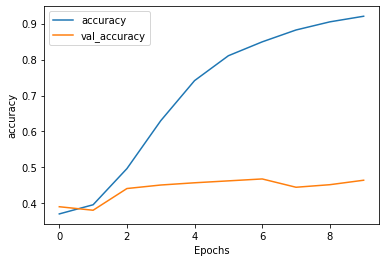

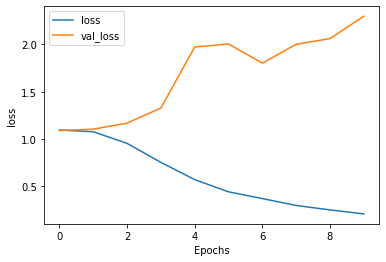

In [62]:
plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

In [ ]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)
  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  return (predictions)

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>